In [1]:
import os
from glob import glob

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def get_moving_average(input_array, window_size=7):

    data_length = len(input_array)

    half_window_size = int((window_size - 1) / 2)

    window_average_cache = []

    for i in range(data_length):
        # if i < half_window_size:
        #     window_average_cache.append(input_array[i])
        temp = []
        for j in list(range(-int(window_size / 2), int(window_size / 2) + 1, 1)):
            try:
                out_index = i + j
                if out_index < 0:
                    temp.append(input_array[i])
                else:
                    temp.append(input_array[out_index])
            except Exception as e:
                pass
        window_average = np.nanmean(temp)
        window_average_cache.append(window_average)

    return window_average_cache


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
def round_number(num):
    import sys

    abs_num = abs(num)
    round_abs_num = round(abs_num, 1)

    while round_abs_num % 5 != 0 and round_abs_num < abs_num * 10:
        _temp = round(round_abs_num)
        _temp += 1
        round_abs_num = _temp

    if num < 0:
        result = -round_abs_num
    else:
        result = round_abs_num

    return result


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
def string_to_datetime(input_string):
    import sys
    from datetime import datetime

    string_len = len(input_string)  # YYYYMMDD ~ 8 letters
    if string_len < 8:
        sys.exit("Wrong format, must be YYYYMMDD, yours is {}".format(input_string))
    else:
        year = input_string[:4]
        month = input_string[4:6]
        day = input_string[6:]

    string_form = "{}/{}/{}".format(year, month, day)
    datetime_form = datetime.strptime(string_form, "%Y/%m/%d")
    return [string_form, datetime_form]


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - -
def round_to_nearest_ten(number, position, base=10):
    """
    Round a number to the nearest 10 based on the given position.

    Args:
        number (float): The number to be rounded.
        position (str): The position to round the number to. Valid values are "top" and "bottom".

    Returns:
        float: The rounded number.

    Raises:
        ValueError: If the position parameter is not "top" or "bottom".

    Example:
        >>> round_to_nearest_ten(11.3, "top")
        20
        >>> round_to_nearest_ten(11.3, "bottom")
        10
        >>> round_to_nearest_ten(-11.3, "top")
        -10
        >>> round_to_nearest_ten(-11.3, "bottom")
        -20
    """
    if position == "top":
        if number >= 0:
            return int(number / base + 1) * base
        else:
            return int(number / base) * base
    elif position == "bottom":
        if number >= 0:
            return int(number / base) * base
        else:
            return int(number / base - 1) * base
    else:
        raise ValueError("Invalid position parameter. Valid values are 'top' and 'bottom'.")

In [3]:
def plot_cross_section(average_filepath, stdev_filepath, savefig="n", DPI=150):
    # - - - - - - - - - - - - - - - - - - - - - - - -
    savefigure_option = savefig
    dot_per_inch = DPI
    # - - - - - - - - - - - - - - - - - - - - - - - -
    average_geodata = pd.read_excel(average_filepath)
    stdev_geodata = pd.read_excel(stdev_filepath)
    # - - - - - - - - - - - - - - - - - - - - - - - -
    basename = os.path.basename(mean_excel2process[index]).split(".")[0]
    segment_element = basename.split("_")[-2:]
    segment_name = "_".join(segment_element)
    # - - - - - - - - - - - - - - - - - - - - - - - -
    selected_datetime = average_geodata.columns[1:-1]
    x_values_from_segment = [
        np.float64(segment.split("_")[-1]) / 1000 for segment in average_geodata["Segment"]
    ]
    # - - - - - - - - - - - - - - - - - - - - - - - -
    lw = 3.5
    alpha = 1

    # Define the Figure

    ## Style
    plt.style.use("seaborn-v0_8-bright")
    ## Convert to centimeter
    cm = 1 / 2.54
    ## Figure variable declaration
    fig = plt.figure(figsize=[22.78 * cm, 16 * cm])
    ## Subplot
    ax = fig.add_subplot(111)
    ## I would like to add a Y-axis on the right side of the graph
    ax2 = ax.twinx()

    # Set the titile of the graph
    # ax.set_title(segment_title, fontsize=24, fontweight="bold")

    # An empty set to store all cumulative displacement value
    # Later will be used for ylim
    all_values = set()

    # Plotting Quantity
    plot_quantity, plot_unit = ["Cumulative Displacement", "(mm)"]

    # = = = = = = = = = = = = = = = = = = = = = = = = = =
    # - - - - - - - - - - - - - - - - GRAPH LABELS - - - - - - - - - - - - - - - -
    # = = = = = = = = = = = = = = = = = = = = = = = = = =
    # x label & y label
    y_label = "{} {}".format(plot_quantity, plot_unit)
    # ax.set_ylabel(y_label, fontsize=20, labelpad=5, fontweight="bold")
    # ax.set_xlabel("Distance (km)", fontsize=20, labelpad=5, fontweight="bold")

    # The length of Y ticks and Label Size
    ax.tick_params(axis="y", which="major", labelsize=20, direction="out", length=10)
    ax2.tick_params(axis="y", which="major", labelsize=20, direction="out", length=10)
    # ax.tick_params(axis="y", which="minor", labelsize=20, direction="out", length=6)

    # The length of X ticks and Label Size
    ax.tick_params(axis="x", which="major", labelsize=20, direction="out", length=10, width=1)
    ax.tick_params(axis="x", which="minor", labelsize=20, direction="out", length=6, width=1)

    # Removing the default axis on right and top sides:
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)

    for side in ["left", "top"]:
        ax2.spines[side].set_visible(False)

    # Define the intervals of X ticks
    x_major_loc = plticker.MultipleLocator(base=1.0)
    x_minor_loc = plticker.MultipleLocator(base=0.5)
    ax.xaxis.set_major_locator(x_major_loc)
    ax.xaxis.set_minor_locator(x_minor_loc)

    # Define the intervals of Y ticks
    y_major_loc = plticker.MultipleLocator(base=50.0)
    y_minor_loc = plticker.MultipleLocator(base=10.0)
    ax.yaxis.set_major_locator(y_major_loc)
    # ax.yaxis.set_minor_locator(y_minor_loc)
    ax2.yaxis.set_major_locator(y_major_loc)

    # This is used to remove the label of the right-side Y axis
    plt.setp(ax2.get_yticklabels(), visible=False)

    # = = = = = = = = = = = = = = = = = = = = = = = = = =
    # - - - - - - -  CUMULATIVE DISPLACEMENT LINES - - - - - - - - - -
    # = = = = = = = = = = = = = = = = = = = = = = = = = =
    # Colorbar
    # Each color corresponding to a value
    cmap = plt.get_cmap("jet")
    count = 1

    # Format-modified input datetime
    modified_datetime = []

    for datetime in selected_datetime[::]:

        # Because the datetime columns should have "N+date"
        # so that it can be used by ArcGIS
        # since ArcGIS can misunderstand the column with only numbers
        if "N" not in datetime:
            date_column = "N" + datetime
        else:
            date_column = datetime
            datetime = datetime[1:]

        # Add the datetime after modifying the format to empty list
        # This will be used to add the label for colorbar below
        modified_datetime.append(datetime)

        # Each color is corresponding to a value
        # This line is to control the plotting color
        color = cmap(float(count) / len(selected_datetime))

        # Extract the mean value & stdev
        # corresponding to each datetime and each HSR segment
        mean_values_from_column = average_geodata[date_column].values
        stdev_values_from_column = stdev_geodata[date_column].values

        # Append all values into one list
        # To find the maximum and minimum values
        # Can be use for top and bot of ylim
        all_values.update(mean_values_from_column)

        # Label for legends
        label = "/".join([datetime[:4], datetime[4:6], datetime[-2:]])

        # This is for drawing the area between two lines
        # Using ax.fill_between() function
        mean_minus_std = mean_values_from_column - stdev_values_from_column
        mean_plus_std = mean_values_from_column + stdev_values_from_column

        # Apply the Moving Average
        # To smooth the line
        MA_mean_values_from_column = get_moving_average(mean_values_from_column, window_size=11)

        # This is the most important line
        # To draw your fucking cumulative displacement
        ax.plot(
            x_values_from_segment,
            MA_mean_values_from_column,
            linestyle="-",
            marker=" ",
            color=color,
            linewidth=lw,
            alpha=alpha,
            label=label,
        )
        ax2.plot(
            x_values_from_segment,
            MA_mean_values_from_column,
            linestyle=" ",
            marker=" ",
            color="k",
            linewidth=1,
            alpha=0,
        )

        # lw -= 0.1
        alpha -= round((0.4 / len(selected_datetime)), 3)
        count += 1

    # = = = = = = = = = = = = = = =
    # - - - - - - -  LEGENDS - - - - - - - - - -
    # = = = = = = = = = = = = = = =

    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(
    #     handles[::-1],
    #     labels[::-1],
    #     fontsize=16,
    #     ncol=2,
    #     frameon=False,
    #     loc="lower left",
    #     borderpad=0.15,
    #     handletextpad=0.3,
    #     labelspacing=0.1,
    # )

    # = = = = = = = = = = = = = = =
    # - - - - - - -  COLOR BAR - - - - - - - - -
    # = = = = = = = = = = = = = = =
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=1))
    cbaxes = inset_axes(
        ax,
        width="20%",
        height="2%",
        loc="lower left",
        bbox_to_anchor=(0.5, 0.25, 2, 1),  # (x0, y0, width, height)
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    cbar = fig.colorbar(sm, cax=cbaxes, orientation="horizontal")
    # cbar.ax.set_title("Time Range", fontsize=20, pad=10)
    cbar.ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    # These lines are for setting the color bar labels
    # Labels have format YYYY/MM to show specific milestone in the time range

    ## A temporary variable to assign length of the datetime list
    _len = len(modified_datetime)
    ## The function string_to_datetime return 2 values
    ## Only take the first value, as the datetime in string format
    ## Then only take the YYYY/MM part of the string
    datestring_list = [
        string_to_datetime(modified_datetime[X])[0][:-3]
        for X in [-1, int(_len * 0.75), int(_len * 0.5), int(_len * 0.25), 0]
    ]
    cbar.ax.set_xticklabels(datestring_list[::-1], fontsize=18, rotation=-60)

    # = = = = = = = = = = = = = = = = = = =
    # - - - - - - -  GRAPH X & Y LIMIT - - - - - - - - - -
    # = = = = = = = = = = = = = = = = = = =

    max_value = np.max(list(all_values))
    min_value = np.min(list(all_values))

    # y_top = round_number(max_value) + 40
    y_top = 145
    y_bot = round_number(min_value)
    # y_bot = round_to_nearest_ten(min_value, position='bottom', base=200)
    ax.set_ylim(top=y_top, bottom=y_bot-190)
    # ax.set_ylim(top=y_top, bottom=-300)
    ax.set_xlim(0, x_values_from_segment[-1])

    # = = = = = = = = = = = = = = = = = = =
    # - - - - - - - - - -  GRAPH ARROWS - - - - - - - - -
    # = = = = = = = = = = = = = = = = = = =

    ax.plot(
        (0),
        (1),
        ls="",
        marker="^",
        ms=15,
        color="k",
        transform=ax.get_xaxis_transform(),
        clip_on=False,
    )

    # = = = = = = = = = = = = = = = = = = =
    # - - - - - - - - - -  SAVE FIGURES - - - - - - - - - - -
    # = = = = = = = = = = = = = = = = = = =

    for i in range(1, 1000):
        savename = "CDIS_CrossHSR_{}_{}.png".format(segment_name, str(i).zfill(3))
        savepath = os.path.join(folder2savefigure, savename)
        if os.path.exists(savepath):
            continue
        else:
            break

    if savefigure_option.lower() in ["y", "yes"]:
        plt.savefig(
            os.path.join(savepath),
            dpi=dot_per_inch,
            transparent=False,
            facecolor="w",
            edgecolor="w",
            bbox_inches="tight",
        )
    plt.show()

In [4]:
mainfolder = r"E:\012_HOPE_TO_PUBLISH_PAPER\PROCESS_023\15_CALIBRATION_v003\HSR_PROFILE_Manuscript\CROSSTrackProfile\CR_PSC_CSV_Export"
folder2savefigure = r"E:\012_HOPE_TO_PUBLISH_PAPER\PROCESS_023\15_CALIBRATION_v003\HSR_PROFILE_Manuscript\CROSSTrackProfile\CR_PSC_PlotGraph"

if not os.path.exists(folder2savefigure):
    os.makedirs(folder2savefigure)

mean_excel2process = glob(os.path.join(mainfolder, "Mean_Output_*"))
stdev_excel2process = glob(os.path.join(mainfolder, "Stdev_Output_*"))

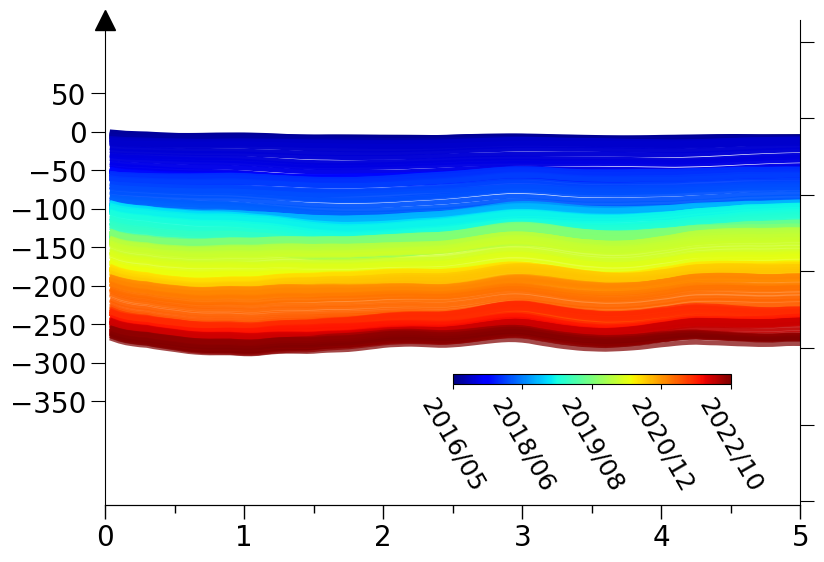

In [8]:
index = 3
PSC_average_filepath = mean_excel2process[index]
PSC_stdev_filepath = stdev_excel2process[index]

plot_cross_section(
    average_filepath=PSC_average_filepath, stdev_filepath=PSC_stdev_filepath, savefig="y", DPI=1200
)